In [27]:
import copy
import numpy as np
import matplotlib.pyplot as plt

In [28]:
from dubins_planner import DubinsPath

In [29]:
class Node:
    def __init__(self, x, y, yaw):
        self.x = x
        self.y = y
        self.path_x = []
        self.path_y = []
        self.parent = None
        self.cost = 0.0
        self.yaw = yaw
        self.path_yaw = []

In [84]:
class RRTStarDubins:
    def __init__(self, start, goal, obstacle_list, rand_area,
                 goal_sample_rate=10,
                 max_iter=250,
                 connect_circle_dist=50.0,
                 robot_radius=0.0,
                 ):

        self.start = Node(start[0], start[1], start[2])
        self.end = Node(goal[0], goal[1], goal[2])
        self.min_rand = rand_area[0]
        self.max_rand = rand_area[1]
        self.goal_sample_rate = goal_sample_rate
        self.max_iter = max_iter
        self.obstacle_list = obstacle_list
        self.connect_circle_dist = connect_circle_dist

        self.curvature = 2 # for dubins path
        self.goal_yaw_th = np.deg2rad(1.0)
        self.goal_xy_th = 0.05
        self.robot_radius = robot_radius
        self.dubbins_planner = DubinsPath()

    def planning(self, search_until_max_iter=True):

        self.node_list = [self.start]
        for i in range(self.max_iter):
            print("Iter:", i, ", number of nodes:", len(self.node_list))
            rnd = self.get_random_node()
            nearest_ind = self.get_nearest_node_index(self.node_list, rnd)
            new_node = self.steer(self.node_list[nearest_ind], rnd)

            if self.check_collision(new_node, self.obstacle_list, self.robot_radius):
                near_indexes = self.find_near_nodes(new_node)
                new_node = self.choose_parent(new_node, near_indexes)
                if new_node:
                    self.node_list.append(new_node)
                    self.rewire(new_node, near_indexes)

            if (not search_until_max_iter) and new_node:  # check reaching the goal
                last_index = self.search_best_goal_node()
                if last_index:
                    return self.generate_final_course(last_index)

        print("reached max iteration")

        last_index = self.search_best_goal_node()
        if last_index:
            return self.generate_final_course(last_index)
        else:
            print("Cannot find path")

        return None

    def choose_parent(self, new_node, near_inds):
        """
        Computes the cheapest point to new_node contained in the list
        near_inds and set such a node as the parent of new_node.
            Arguments:
            --------
                new_node, Node
                    randomly generated node with a path from its neared point
                    There are not coalitions between this node and th tree.
                near_inds: list
                    Indices of indices of the nodes what are near to new_node

            Returns.
            ------
                Node, a copy of new_node
        """
        if not near_inds:
            return None

        # search nearest cost in near_inds
        costs = []
        for i in near_inds:
            near_node = self.node_list[i]
            t_node = self.steer(near_node, new_node)
            if t_node and self.check_collision(
                    t_node, self.obstacle_list, self.robot_radius):
                costs.append(self.calc_new_cost(near_node, new_node))
            else:
                costs.append(float("inf"))  # the cost of collision node
        min_cost = min(costs)

        if min_cost == float("inf"):
            print("There is no good path.(min_cost is inf)")
            return None

        min_ind = near_inds[costs.index(min_cost)]
        new_node = self.steer(self.node_list[min_ind], new_node)
        new_node.cost = min_cost

        return new_node

    def search_best_goal_node(self):

        goal_indexes = []
        for (i, node) in enumerate(self.node_list):
            if self.calc_dist_to_goal(node.x, node.y) <= self.goal_xy_th:
                goal_indexes.append(i)

        # angle check
        final_goal_indexes = []
        for i in goal_indexes:
            if abs(self.node_list[i].yaw - self.end.yaw) <= self.goal_yaw_th:
                final_goal_indexes.append(i)

        if not final_goal_indexes:
            return None

        min_cost = min([self.node_list[i].cost for i in final_goal_indexes])
        for i in final_goal_indexes:
            if self.node_list[i].cost == min_cost:
                return i

        return None

    def find_near_nodes(self, new_node):
        """"""  """
        1) defines a ball centered on new_node
        2) Returns all nodes of the three that are inside this ball
            Arguments:
            ---------
                new_node: Node
                    new randomly generated node, without collisions between
                    its nearest node
            Returns:
            -------
                list
                    List with the indices of the nodes inside the ball of
                    radius r
        """
        nnode = len(self.node_list) + 1
        r = self.connect_circle_dist * np.sqrt(np.log(nnode) / nnode)

        dist_list = [(node.x - new_node.x)**2 + (node.y - new_node.y)**2
                     for node in self.node_list]
        near_inds = [dist_list.index(i) for i in dist_list if i <= r**2]
        return near_inds

    def rewire(self, new_node, near_inds):
        """
            For each node in near_inds, this will check if it is cheaper to
            arrive to them from new_node.
            In such a case, this will re-assign the parent of the nodes in
            near_inds to new_node.
            Parameters:
            ----------
                new_node, Node
                    Node randomly added which can be joined to the tree

                near_inds, list of uints
                    A list of indices of the self.new_node which contains
                    nodes within a circle of a given radius.
            Remark: parent is designated in choose_parent.

        """
        for i in near_inds:
            near_node = self.node_list[i]
            edge_node = self.steer(new_node, near_node)
            if not edge_node:
                continue
            edge_node.cost = self.calc_new_cost(new_node, near_node)

            no_collision = self.check_collision(
                edge_node, self.obstacle_list, self.robot_radius)
            improved_cost = near_node.cost > edge_node.cost

            if no_collision and improved_cost:
                for node in self.node_list:
                    if node.parent == near_node:
                        node.parent = edge_node
                self.near_node = edge_node
                self.propagate_cost_to_leaves(self.near_node)

    def calc_new_cost(self, from_node, to_node):

        _, _, _, _, course_lengths = self.dubbins_planner.plan_dubins_path(
            from_node.x, from_node.y, from_node.yaw,
            to_node.x, to_node.y, to_node.yaw, self.curvature)

        cost = sum([abs(c) for c in course_lengths])

        return from_node.cost + cost

    def propagate_cost_to_leaves(self, parent_node):

        for node in self.node_list:
            if node.parent == parent_node:
                node.cost = self.calc_new_cost(parent_node, node)
                self.propagate_cost_to_leaves(node)

    def steer(self, from_node, to_node):

        px, py, pyaw, mode, course_lengths = \
            self.dubbins_planner.plan_dubins_path(
                from_node.x, from_node.y, from_node.yaw,
                to_node.x, to_node.y, to_node.yaw, self.curvature)

        if len(px) <= 1:  # cannot find a dubins path
            return None

        # new_node = copy.deepcopy(from_node)
        new_node = Node(px[-1], py[-1], pyaw[-1])
        # new_node.x = px[-1]
        # new_node.y = py[-1]
        # new_node.yaw = pyaw[-1]

        new_node.path_x = px
        new_node.path_y = py
        new_node.path_yaw = pyaw
        new_node.cost += sum([abs(c) for c in course_lengths])
        new_node.parent = from_node

        return new_node

    def generate_final_course(self, goal_index):
        path = [[self.end.x, self.end.y]]
        node = self.node_list[goal_index]
        while node.parent:
            for (ix, iy) in zip(reversed(node.path_x), reversed(node.path_y)):
                path.append([ix, iy])
            node = node.parent
        path.append([self.start.x, self.start.y])
        return path

    def calc_dist_to_goal(self, x, y):
        dx = x - self.end.x
        dy = y - self.end.y
        return np.hypot(dx, dy)

    def get_random_node(self):

        if np.random.randint(0, 100) > self.goal_sample_rate:
            rnd = Node(np.random.uniform(self.min_rand, self.max_rand),
                       np.random.uniform(self.min_rand, self.max_rand),
                       np.random.uniform(-np.pi, np.pi)
                       )
        else:  # goal point sampling
            rnd = Node(self.end.x, self.end.y, self.end.yaw)

        return rnd

    @staticmethod
    def get_nearest_node_index(node_list, rnd_node):
        dlist = [(node.x - rnd_node.x)**2 + (node.y - rnd_node.y)**2
                 for node in node_list]
        minind = dlist.index(min(dlist))

        return minind

    @staticmethod
    def check_collision(node, obstacleList, robot_radius):

        if node is None:
            return False

        for (ox, oy, size) in obstacleList:
            dx_list = [ox - x for x in node.path_x]
            dy_list = [oy - y for y in node.path_y]
            d_list = [dx * dx + dy * dy for (dx, dy) in zip(dx_list, dy_list)]

            if min(d_list) <= (size+robot_radius)**2:
                return False  # collision

        return True  # safe

    @staticmethod
    def calc_distance_and_angle(from_node, to_node):
        dx = to_node.x - from_node.x
        dy = to_node.y - from_node.y
        d = np.hypot(dx, dy)
        theta = np.arctan2(dy, dx)
        return d, theta

    def draw_graph(self, rnd=None):  # pragma: no cover
        plt.clf()
        # for stopping simulation with the esc key.
        plt.gcf().canvas.mpl_connect('key_release_event',
                                     lambda event: [exit(0) if event.key == 'escape' else None])
        plt.xlim(-9, 9)
        plt.ylim(-9, 9)
        if rnd is not None:
            plt.plot(rnd.x, rnd.y, "^k")
        for node in self.node_list:
            if node.parent:
                plt.plot(node.path_x, node.path_y, "-g")

        for (ox, oy, size) in self.obstacle_list:
            plt.plot(ox, oy, "ok", ms=30 * size)

        plt.plot(self.start.x, self.start.y, "xr")
        plt.plot(self.end.x, self.end.y, "xr")

In [86]:
obstacleList = [
    [-5.6749, 1.20558, 0.521155],
    [-3.42783, -2.3167, 0.620818],
    [2.07, 5.36304, 0.534224],
    [-2.02172, -3.82217, 0.462809],
    [1.09052, -0.990239, 0.644405],
    [-4, 6.92, 0.01],
    [-4, 6.92, 0.01],
    [-3.6, 6.92, 0.01],
    [-3.2, 6.92, 0.01],
    [-2.8, 6.92, 0.01],
    [-2.4, 6.92, 0.01],
    [-2, 6.92, 0.01],
    [-1.6, 6.92, 0.01],
    [-1.2, 6.92, 0.01],
    [-0.8, 6.92, 0.01],
    [-0.4, 6.92, 0.01],
    [0, 6.92, 0.01],
    [0.4, 6.92, 0.01],
    [0.8, 6.92, 0.01],
    [1.2, 6.92, 0.01],
    [1.6, 6.92, 0.01],
    [2, 6.92, 0.01],
    [2.4, 6.92, 0.01],
    [2.8, 6.92, 0.01],
    [3.2, 6.92, 0.01],
    [3.6, 6.92, 0.01],
    [4, 6.92, 0.01],
    [4.2, 6.574, 0.01],
    [4.4, 6.228, 0.01],
    [4.6, 5.882, 0.01],
    [4.8, 5.536, 0.01],
    [5, 5.19, 0.01],
    [5.2, 4.844, 0.01],
    [5.4, 4.498, 0.01],
    [5.6, 4.152, 0.01],
    [5.8, 3.806, 0.01],
    [6, 3.46, 0.01],
    [6.2, 3.114, 0.01],
    [6.4, 2.768, 0.01],
    [6.6, 2.422, 0.01],
    [6.8, 2.076, 0.01],
    [7, 1.73, 0.01],
    [7.2, 1.384, 0.01],
    [7.4, 1.038, 0.01],
    [7.6, 0.692, 0.01],
    [7.8, 0.346, 0.01],
    [8, 0, 0.01],
    [7.8, -0.346, 0.01],
    [7.6, -0.692, 0.01],
    [7.4, -1.038, 0.01],
    [7.2, -1.384, 0.01],
    [7, -1.73, 0.01],
    [6.8, -2.076, 0.01],
    [6.6, -2.422, 0.01],
    [6.4, -2.768, 0.01],
    [6.2, -3.114, 0.01],
    [6, -3.46, 0.01],
    [5.8, -3.806, 0.01],
    [5.6, -4.152, 0.01],
    [5.4, -4.498, 0.01],
    [5.2, -4.844, 0.01],
    [5, -5.19, 0.01],
    [4.8, -5.536, 0.01],
    [4.6, -5.882, 0.01],
    [4.4, -6.228, 0.01],
    [4.2, -6.574, 0.01],
    [4, -6.92, 0.01],
    [3.6, -6.92, 0.01],
    [3.2, -6.92, 0.01],
    [2.8, -6.92, 0.01],
    [2.4, -6.92, 0.01],
    [2, -6.92, 0.01],
    [1.6, -6.92, 0.01],
    [1.2, -6.92, 0.01],
    [0.8, -6.92, 0.01],
    [0.4, -6.92, 0.01],
    [0, -6.92, 0.01],
    [-0.4, -6.92, 0.01],
    [-0.8, -6.92, 0.01],
    [-1.2, -6.92, 0.01],
    [-1.6, -6.92, 0.01],
    [-2, -6.92, 0.01],
    [-2.4, -6.92, 0.01],
    [-2.8, -6.92, 0.01],
    [-3.2, -6.92, 0.01],
    [-3.6, -6.92, 0.01],
    [-4, -6.92, 0.01],
    [-4.2, -6.574, 0.01],
    [-4.4, -6.228, 0.01],
    [-4.6, -5.882, 0.01],
    [-4.8, -5.536, 0.01],
    [-5, -5.19, 0.01],
    [-5.2, -4.844, 0.01],
    [-5.4, -4.498, 0.01],
    [-5.6, -4.152, 0.01],
    [-5.8, -3.806, 0.01],
    [-6, -3.46, 0.01],
    [-6.2, -3.114, 0.01],
    [-6.4, -2.768, 0.01],
    [-6.6, -2.422, 0.01],
    [-6.8, -2.076, 0.01],
    [-7, -1.73, 0.01],
    [-7.2, -1.384, 0.01],
    [-7.4, -1.038, 0.01],
    [-7.6, -0.692, 0.01],
    [-7.8, -0.346, 0.01],
    [-8, 0, 0.01],
    [-7.8, 0.346, 0.01],
    [-7.6, 0.692, 0.01], [-7.4, 1.038, 0.01],
    [-7.2, 1.384, 0.01],
    [-7, 1.73, 0.01],
    [-6.8, 2.076, 0.01],
    [-6.6, 2.422, 0.01],
    [-6.4, 2.768, 0.01],
    [-6.2, 3.114, 0.01],
    [-6, 3.46, 0.01],
    [-5.8, 3.806, 0.01],
    [-5.6, 4.152, 0.01],
    [-5.4, 4.498, 0.01],
    [-5.2, 4.844, 0.01],
    [-5, 5.19, 0.01],
    [-4.8, 5.536, 0.01],
    [-4.6, 5.882, 0.01],
    [-4.4, 6.228, 0.01],
    [-4.2, 6.574, 0.01],
]

In [93]:
# np.random.seed(13)
obstacleList = np.array(obstacleList)

# Set Initial parameters
start = [0, -1, np.deg2rad(90)]
goal = [0.18, -6.42, np.deg2rad(-90)]

rnd_min = -9
rnd_max = 9

rrtstar_dubins = RRTStarDubins(start, goal, rand_area=[
                               rnd_min, rnd_max], obstacle_list=obstacleList, robot_radius=0.353)

In [94]:
%%time
path = rrtstar_dubins.planning(search_until_max_iter=False)

Iter: 0 , number of nodes: 1
Iter: 1 , number of nodes: 1
Iter: 2 , number of nodes: 2
Iter: 3 , number of nodes: 2
Iter: 4 , number of nodes: 2
Iter: 5 , number of nodes: 2
Iter: 6 , number of nodes: 2
Iter: 7 , number of nodes: 2
Iter: 8 , number of nodes: 2
Iter: 9 , number of nodes: 2
Iter: 10 , number of nodes: 2
Iter: 11 , number of nodes: 2
Iter: 12 , number of nodes: 2
Iter: 13 , number of nodes: 2
Iter: 14 , number of nodes: 2
Iter: 15 , number of nodes: 2
Iter: 16 , number of nodes: 2
Iter: 17 , number of nodes: 2
Iter: 18 , number of nodes: 2
Iter: 19 , number of nodes: 2
Iter: 20 , number of nodes: 3
Iter: 21 , number of nodes: 3
Iter: 22 , number of nodes: 3
Iter: 23 , number of nodes: 3
Iter: 24 , number of nodes: 3
Iter: 25 , number of nodes: 3
Iter: 26 , number of nodes: 3
Iter: 27 , number of nodes: 3
Iter: 28 , number of nodes: 3
Iter: 29 , number of nodes: 3
Iter: 30 , number of nodes: 3
Iter: 31 , number of nodes: 3
Iter: 32 , number of nodes: 3
Iter: 33 , number of

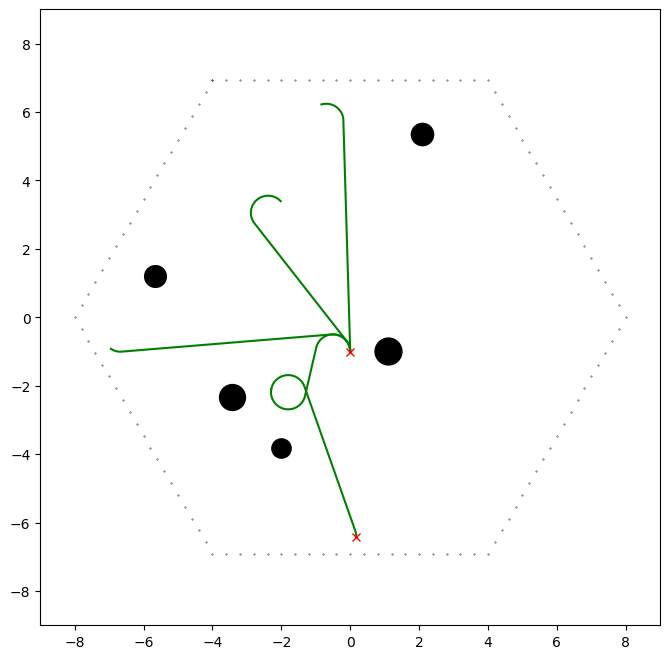

In [95]:
plt.figure(figsize=(8, 8))
rrtstar_dubins.draw_graph()
# plt.figure(figsize=(8, 8))
# plt.xlim(-2, 17)
# plt.ylim(-2, 17)
# plt.plot([x for (x, y) in path], [y for (x, y) in path], '-r')
# # plt.scatter([x for (x, y) in path], [y for (x, y) in path])
# plt.grid(True)
# plt.show()

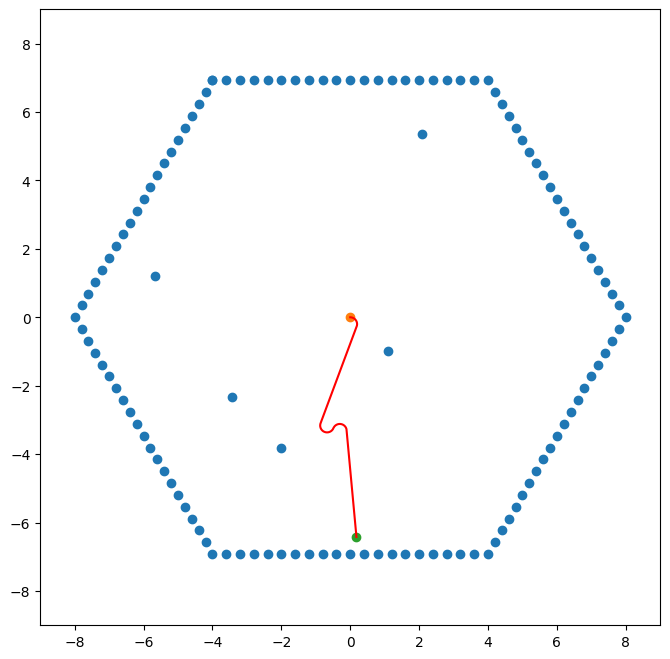

In [57]:
plt.figure(figsize=(8, 8))
plt.xlim(-9, 9)
plt.ylim(-9, 9)
plt.scatter(obstacleList[...,0], obstacleList[...,1])
plt.scatter(start[0], start[1])
plt.scatter(goal[0], goal[1])
plt.plot([x for (x, y) in path], [y for (x, y) in path], color="red")
plt.show()

In [178]:
path

[[0.92, 6.42],
 [0.9200000000000008, 6.42],
 [0.9044600184911635, 6.244391139197424],
 [0.8820101863810117, 6.1469864448435345],
 [0.8499482664868294, 6.0523096116864865],
 [0.8085946109139375, 5.961306619347185],
 [0.7583624117191201, 5.874886739643492],
 [0.6997535724321735, 5.793913451446795],
 [0.6333536932017467, 5.719195813086545],
 [0.5598262196722281, 5.651480378506868],
 [0.47990581405417343, 5.5914437379463395],
 [0.3943910146223448, 5.539685757671965],
 [0.30413625698523106, 5.496723586313731],
 [0.21004333684688437, 5.462986487686446],
 [0.11305239956234381, 5.438811551727589],
 [0.014132546516015143, 5.424440326406091],
 [-0.08572784781901843, 5.420016404254868],
 [-0.185531011392019, 5.425583987641702],
 [-0.2842797439831046, 5.44108744711379],
 [-0.45601530483009833, 5.4769252717480565],
 [-0.5539065601187194, 5.497353246146368],
 [-0.6517978154073405, 5.517781220544678],
 [-0.7496890706959618, 5.538209194942989],
 [-0.8475803259845827, 5.558637169341299],
 [-0.945471581

In [179]:
path_cpp = [
    [10, 10],
    [10, 10],
    [9.82437, 9.98446],
    [9.72697, 9.96201],
    [9.63229, 9.92994],
    [9.54129, 9.88859],
    [9.45487, 9.83835],
    [9.3739, 9.77974],
    [9.29918, 9.71334],
    [9.23147, 9.63981],
    [9.17143, 9.55989],
    [9.11968, 9.47438],
    [9.07672, 9.38412],
    [9.04298, 9.29003],
    [9.01881, 9.19304],
    [9.00444, 9.09412],
    [9.00002, 8.99425],
    [9.00559, 8.89445],
    [9.02109, 8.7957],
    [9.04638, 8.699],
    [9.08119, 8.6053],
    [9.12519, 8.51554],
    [9.17792, 8.43063],
    [9.23887, 8.3514],
    [9.32494, 8.2504],
    [9.3898, 8.17428],
    [9.45466, 8.09817],
    [9.51952, 8.02206],
    [9.58438, 7.94595],
    [9.64924, 7.86983],
    [9.7141, 7.79372],
    [9.77896, 7.71761],
    [9.84382, 7.64149],
    [9.90868, 7.56538],
    [9.97354, 7.48927],
    [10.0384, 7.41316],
    [10.1033, 7.33704],
    [10.1681, 7.26093],
    [10.233, 7.18482],
    [10.2978, 7.1087],
    [10.3627, 7.03259],
    [10.4276, 6.95648],
    [10.4924, 6.88037],
    [10.5573, 6.80425],
    [10.6221, 6.72814],
    [10.687, 6.65203],
    [10.7519, 6.57591],
    [10.8167, 6.4998],
    [10.8816, 6.42369],
    [10.9464, 6.34758],
    [11.0113, 6.27146],
    [11.0762, 6.19535],
    [11.141, 6.11924],
    [11.2059, 6.04312],
    [11.2707, 5.96701],
    [11.3356, 5.8909],
    [11.4005, 5.81479],
    [11.4653, 5.73867],
    [11.5302, 5.66256],
    [11.595, 5.58645],
    [11.6599, 5.51033],
    [11.7248, 5.43422],
    [11.7896, 5.35811],
    [11.8545, 5.282],
    [11.9193, 5.20588],
    [11.9842, 5.12977],
    [12.0491, 5.05366],
    [12.1139, 4.97754],
    [12.1788, 4.90143],
    [12.2436, 4.82532],
    [12.3085, 4.74921],
    [12.3734, 4.67309],
    [12.4382, 4.59698],
    [12.5031, 4.52087],
    [12.5679, 4.44475],
    [12.6328, 4.36864],
    [12.6977, 4.29253],
    [12.7625, 4.21642],
    [12.8274, 4.1403],
    [12.8922, 4.06419],
    [12.9571, 3.98808],
    [13.022, 3.91196],
    [13.0868, 3.83585],
    [13.1517, 3.75974],
    [13.2165, 3.68363],
    [13.2814, 3.60751],
    [13.3463, 3.5314],
    [13.4111, 3.45529],
    [13.491, 3.34768],
    [13.5408, 3.26101],
    [13.5817, 3.16981],
    [13.6133, 3.07497],
    [13.6353, 2.97746],
    [13.6474, 2.87824],
    [13.6474, 2.87824],
    [13.6476, 2.73731],
    [13.6357, 2.63807],
    [13.6139, 2.54051],
    [13.5825, 2.4456],
    [13.5418, 2.35431],
    [13.4922, 2.26754],
    [13.4342, 2.18615],
    [13.3683, 2.11096],
    [13.2953, 2.04273],
    [13.2158, 1.98212],
    [13.1306, 1.92976],
    [13.0407, 1.88616],
    [12.9468, 1.85176],
    [12.85, 1.82689],
    [12.7435, 1.80515],
    [12.6455, 1.78515],
    [12.5475, 1.76514],
    [12.4495, 1.74514],
    [12.3516, 1.72514],
    [12.2536, 1.70514],
    [12.1556, 1.68514],
    [12.0576, 1.66514],
    [11.9596, 1.64514],
    [11.8617, 1.62514],
    [11.7637, 1.60514],
    [11.6657, 1.58514],
    [11.5677, 1.56513],
    [11.4697, 1.54513],
    [11.3718, 1.52513],
    [11.2738, 1.50513],
    [11.1758, 1.48513],
    [11.0778, 1.46513],
    [10.9799, 1.44513],
    [10.8819, 1.42513],
    [10.7839, 1.40513],
    [10.6859, 1.38513],
    [10.5879, 1.36513],
    [10.49, 1.34512],
    [10.392, 1.32512],
    [10.294, 1.30512],
    [10.196, 1.28512],
    [10.098, 1.26512],
    [10.0001, 1.24512],
    [9.90208, 1.22512],
    [9.8041, 1.20512],
    [9.70612, 1.18512],
    [9.60814, 1.16512],
    [9.51016, 1.14512],
    [9.41218, 1.12511],
    [9.3142, 1.10511],
    [9.21622, 1.08511],
    [9.11824, 1.06511],
    [9.02026, 1.04511],
    [8.92228, 1.02511],
    [8.8243, 1.00511],
    [8.72632, 0.985107],
    [8.62835, 0.965107],
    [8.53037, 0.945106],
    [8.43239, 0.925105],
    [8.33441, 0.905104],
    [8.23643, 0.885103],
    [8.13845, 0.865102],
    [8.04047, 0.845101],
    [7.94249, 0.8251],
    [7.84451, 0.805099],
    [7.74653, 0.785098],
    [7.64855, 0.765097],
    [7.55057, 0.745096],
    [7.45259, 0.725095],
    [7.35461, 0.705094],
    [7.25663, 0.685093],
    [7.15865, 0.665092],
    [7.06067, 0.645091],
    [6.9627, 0.625091],
    [6.86472, 0.60509],
    [6.76674, 0.585089],
    [6.66876, 0.565088],
    [6.57078, 0.545087],
    [6.4728, 0.525086],
    [6.37482, 0.505085],
    [6.27684, 0.485084],
    [6.17886, 0.465083],
    [6.08088, 0.445082],
    [5.9829, 0.425081],
    [5.88492, 0.40508],
    [5.78694, 0.385079],
    [5.68896, 0.365078],
    [5.59098, 0.345077],
    [5.493, 0.325076],
    [5.39502, 0.305075],
    [5.29705, 0.285075],
    [5.19907, 0.265074],
    [5.10109, 0.245073],
    [5.00311, 0.225072],
    [4.90513, 0.205071],
    [4.80715, 0.18507],
    [4.70917, 0.165069],
    [4.61119, 0.145068],
    [4.51321, 0.125067],
    [4.41523, 0.105066],
    [4.31725, 0.0850651],
    [4.21927, 0.0650642],
    [4.12129, 0.0450632],
    [4.02331, 0.0250623],
    [3.92533, 0.00506136],
    [3.82735, -0.0149396],
    [3.72938, -0.0349405],
    [3.6314, -0.0549415],
    [3.53342, -0.0749424],
    [3.43544, -0.0949433],
    [3.33746, -0.114944],
    [3.23948, -0.134945],
    [3.1415, -0.154946],
    [3.04352, -0.174947],
    [2.94554, -0.194948],
    [2.84756, -0.214949],
    [2.74958, -0.23495],
    [2.6516, -0.254951],
    [2.55362, -0.274952],
    [2.45564, -0.294953],
    [2.35766, -0.314954],
    [2.25968, -0.334955],
    [2.1617, -0.354956],
    [2.06373, -0.374957],
    [1.96575, -0.394957],
    [1.86777, -0.414958],
    [1.76979, -0.434959],
    [1.67181, -0.45496],
    [1.57383, -0.474961],
    [1.47585, -0.494962],
    [1.37787, -0.514963],
    [1.27989, -0.534964],
    [1.18191, -0.554965],
    [1.08393, -0.574966],
    [0.985952, -0.594967],
    [0.887973, -0.614968],
    [0.789993, -0.634969],
    [0.692014, -0.65497],
    [0.594034, -0.674971],
    [0.496055, -0.694972],
    [0.398076, -0.714973],
    [0.300096, -0.734973],
    [0.202117, -0.754974],
    [0.104137, -0.774975],
    [0.00615809, -0.794976],
    [-0.0918213, -0.814977],
    [-0.189801, -0.834978],
    [-0.28778, -0.854979],
    [-0.385759, -0.87498],
    [-0.483739, -0.894981],
    [-0.581718, -0.914982],
    [-0.679698, -0.934983],
    [-0.777677, -0.954984],
    [-0.875656, -0.974985],
    [-0.973636, -0.994986],
    [-1, -1],
    [-1, -1]
]

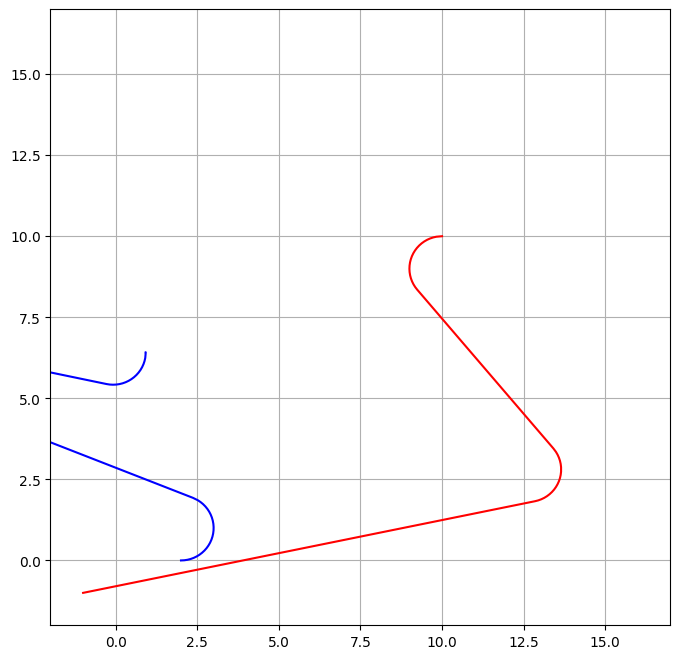

In [180]:
plt.figure(figsize=(8, 8))
plt.xlim(-2, 17)
plt.ylim(-2, 17)
plt.plot([x for (x, y) in path_cpp], [y for (x, y) in path_cpp], color='red')
plt.plot([x for (x, y) in path], [y for (x, y) in path], color='blue')

# plt.scatter([x for (x, y) in path], [y for (x, y) in path])
plt.grid(True)
plt.show()

In [181]:
import numpy as np
from dubins_planner import DubinsPath
import matplotlib.pyplot as plt

In [182]:
dubins = DubinsPath()

In [183]:
start_x = 1.0  # [m]
start_y = 1.0  # [m]
start_yaw = np.deg2rad(45.0)  # [rad]

end_x = -3.0  # [m]
end_y = -3.0  # [m]
end_yaw = np.deg2rad(-45.0)  # [rad]

curvature = 1.0

path_x, path_y, path_yaw, mode, lengths = dubins.plan_dubins_path(start_x,
                                                                  start_y,
                                                                  start_yaw,
                                                                  end_x,
                                                                  end_y,
                                                                  end_yaw,
                                                                  curvature)

In [184]:
cpp_path_x = [1, 1.06706, 1.12639, 1.17738, 1.21954, 1.25244, 1.27576, 1.28925, 1.29279, 1.28633, 1.26995, 1.24381, 1.20817, 1.16338, 1.1099, 1.04825, 0.979051, 0.902999, 0.820851, 0.733428, 0.641603, 0.546294, 0.448453, 0.349058, 0.249102, 0.149583, 0.0514959, -0.0441791, -0.136486, -0.224503, -0.30735, -0.3842, -0.454285, -0.546911, -0.6012, -0.655489, -0.709778, -0.764067, -0.818356, -0.872645, -0.926934, -0.981222, -1.03551, -1.0898, -1.14409, -1.19838, -
              1.25267, -1.30696, -1.36124, -1.41553, -1.46982, -1.52411, -1.5784, -1.63269, -1.68698, -1.74127, -1.79556, -1.84984, -1.90413, -1.95842, -2.01271, -2.067, -2.12129, -2.17558, -2.22987, -2.28416, -2.33844, -2.39273, -2.44702, -2.50131, -2.5556, -2.60989, -2.66418, -2.71847, -2.77276, -2.82704, -2.88133, -2.93562, -2.98991, -3.0442, -3.1327, -3.1827, -3.22381, -3.25562, -3.27782, -3.29017, -3.29255, -3.28495, -3.26744, -3.24018, -3.20347, -3.15765, -3.1032, -3]
cpp_path_y = [1, 1.07413, 1.15458, 1.24055, 1.33118, 1.42557, 1.52277, 1.62181, 1.72171, 1.82146, 1.92007, 2.01654, 2.10993, 2.1993, 2.28374, 2.36242, 2.43456, 2.49943, 2.55638, 2.60484, 2.64434, 2.67447, 2.69493, 2.70553, 2.70615, 2.69678, 2.67753, 2.64859, 2.61023, 2.56285, 2.50692, 2.443, 2.37173, 2.25, 2.16602, 2.08203, 1.99805, 1.91407, 1.83009, 1.74611, 1.66213, 1.57815, 1.49417, 1.41019, 1.32621, 1.24223, 1.15825, 1.07427, 0.990289,
              0.906308, 0.822328, 0.738347, 0.654367, 0.570386, 0.486406, 0.402426, 0.318445, 0.234465, 0.150484, 0.0665037, -0.0174768, -0.101457, -0.185438, -0.269418, -0.353399, -0.437379, -0.52136, -0.60534, -0.68932, -0.773301, -0.857281, -0.941262, -1.02524, -1.10922, -1.1932, -1.27718, -1.36116, -1.44514, -1.52912, -1.61311, -1.75, -1.83656, -1.92767, -2.02243, -2.11989, -2.21909, -2.31902, -2.41869, -2.5171, -2.61327, -2.70624, -2.79508, -2.8789, -3]

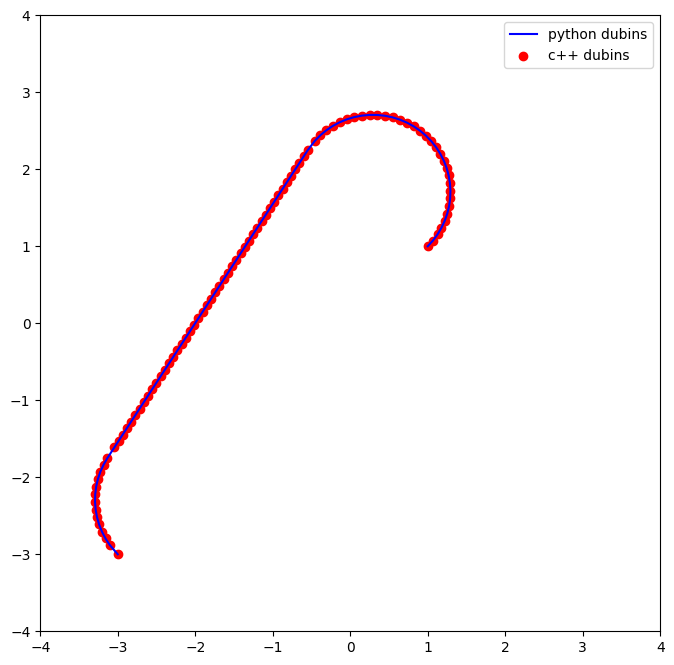

In [185]:
plt.figure(figsize=(8, 8))
plt.xlim(-4, 4)
plt.ylim(-4, 4)
plt.plot(path_x, path_y, color="blue", label='python dubins')
plt.scatter(cpp_path_x, cpp_path_y, color="red", label='c++ dubins')
plt.legend()
plt.show()

In [186]:
def angle_mod(x, zero_2_2pi=False, degree=False):
    if degree:
        x = x * (np.pi / 180.0)

    if zero_2_2pi:
        mod_angle = x % (2.0 * np.pi)
    else:
        mod_angle = (x + np.pi) % (2.0 * np.pi) - np.pi

    if degree:
        mod_angle = mod_angle * (180.0 / np.pi)

    return mod_angle

In [187]:
angle_mod(3.14, True, False)

3.14

In [188]:
angle_mod(-4.71238898, True, False)

1.5707963271795862

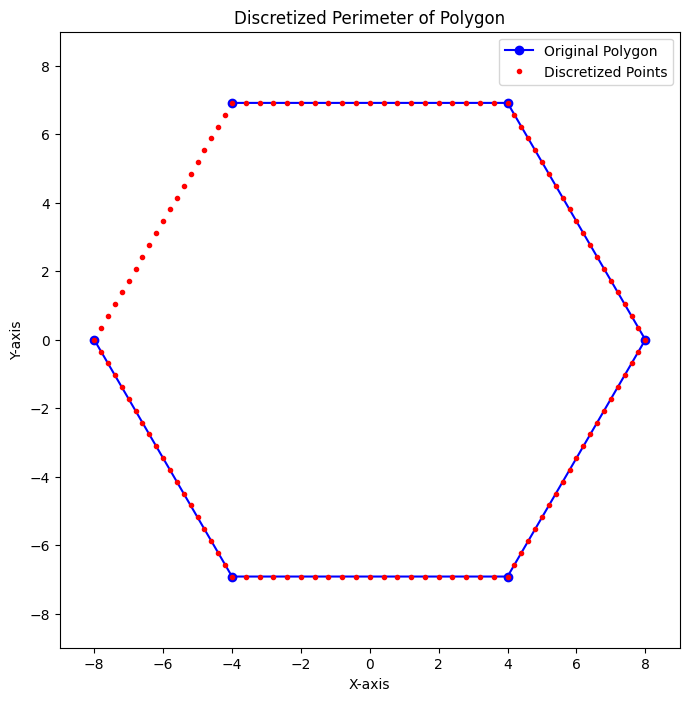

In [189]:
import numpy as np
import matplotlib.pyplot as plt


def discretize_polygon(polygon_vertices, num_points_per_edge):
    points = []

    for i in range(len(polygon_vertices)):
        start_point = polygon_vertices[i]
        # Wrap around for the last edge
        end_point = polygon_vertices[(i + 1) % len(polygon_vertices)]

        x_vals = np.linspace(
            start_point[0], end_point[0], num_points_per_edge, endpoint=False)
        y_vals = np.linspace(
            start_point[1], end_point[1], num_points_per_edge, endpoint=False)

        edge_points = np.column_stack((x_vals, y_vals))
        points.extend(edge_points)

    return np.array(points)


# Example polygon vertices
polygon_vertices = np.array([[-4, 6.92], [4, 6.92], [8, 0], [
                            4, -6.92], [-4, -6.92], [-8, 0]])

# Discretize the perimeter with 100 points per edge
discretized_points = discretize_polygon(
    polygon_vertices, num_points_per_edge=20)

# Plot the original polygon and the discretized points
plt.figure(figsize=(8, 8))
plt.xlim(-9,9)
plt.ylim(-9,9)
plt.plot(polygon_vertices[:, 0], polygon_vertices[:,
         1], 'bo-', label='Original Polygon')
plt.plot(discretized_points[:, 0], discretized_points[:,
         1], 'r.', label='Discretized Points')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Discretized Perimeter of Polygon')
plt.legend()
plt.show()

In [190]:
discretized_points

array([[-4.   ,  6.92 ],
       [-3.6  ,  6.92 ],
       [-3.2  ,  6.92 ],
       [-2.8  ,  6.92 ],
       [-2.4  ,  6.92 ],
       [-2.   ,  6.92 ],
       [-1.6  ,  6.92 ],
       [-1.2  ,  6.92 ],
       [-0.8  ,  6.92 ],
       [-0.4  ,  6.92 ],
       [ 0.   ,  6.92 ],
       [ 0.4  ,  6.92 ],
       [ 0.8  ,  6.92 ],
       [ 1.2  ,  6.92 ],
       [ 1.6  ,  6.92 ],
       [ 2.   ,  6.92 ],
       [ 2.4  ,  6.92 ],
       [ 2.8  ,  6.92 ],
       [ 3.2  ,  6.92 ],
       [ 3.6  ,  6.92 ],
       [ 4.   ,  6.92 ],
       [ 4.2  ,  6.574],
       [ 4.4  ,  6.228],
       [ 4.6  ,  5.882],
       [ 4.8  ,  5.536],
       [ 5.   ,  5.19 ],
       [ 5.2  ,  4.844],
       [ 5.4  ,  4.498],
       [ 5.6  ,  4.152],
       [ 5.8  ,  3.806],
       [ 6.   ,  3.46 ],
       [ 6.2  ,  3.114],
       [ 6.4  ,  2.768],
       [ 6.6  ,  2.422],
       [ 6.8  ,  2.076],
       [ 7.   ,  1.73 ],
       [ 7.2  ,  1.384],
       [ 7.4  ,  1.038],
       [ 7.6  ,  0.692],
       [ 7.8  ,  0.346],
